<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocess-for-MMvec" data-toc-modified-id="Preprocess-for-MMvec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocess for MMvec</a></span></li><li><span><a href="#Perform-paired-t-test-on-dietary-values" data-toc-modified-id="Perform-paired-t-test-on-dietary-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Perform paired t-test on dietary values</a></span><ul class="toc-item"><li><span><a href="#Analyze-more-samples" data-toc-modified-id="Analyze-more-samples-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyze more samples</a></span></li></ul></li><li><span><a href="#Analyze-MMvec-results" data-toc-modified-id="Analyze-MMvec-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze MMvec results</a></span><ul class="toc-item"><li><span><a href="#Dietary-comparisons" data-toc-modified-id="Dietary-comparisons-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dietary comparisons</a></span></li><li><span><a href="#Microbial-comparisons" data-toc-modified-id="Microbial-comparisons-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Microbial comparisons</a></span></li></ul></li><li><span><a href="#Generate-microbe-diet-network" data-toc-modified-id="Generate-microbe-diet-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate microbe-diet network</a></span></li><li><span><a href="#Simplified-dietary-figure" data-toc-modified-id="Simplified-dietary-figure-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simplified dietary figure</a></span></li></ul></div>

In [2]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
from scipy.stats import ttest_rel, ttest_ind

from adjustText import adjust_text

# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

Load taxonomies

In [3]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# Preprocess for MMvec

In [4]:
diaries = pd.read_excel(f'{berding_directory}/diet/ASD_All food diaries.xlsx', 
                        sheet_name='For SAS')
diaries = diaries.dropna(subset=['Subject$'])
diaries['Subject$'] = diaries['Subject$'].apply(lambda x: f'{int(x)}B')
baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
baseline_diary = baseline_diary.iloc[:, 9:]

# save dietary data to intermediate directory
from biom.util import biom_open
with biom_open(f'{berding_directory}/diet/diet.biom', 'w') as f:
    t = biom.Table(baseline_diary.values.T, baseline_diary.columns, baseline_diary.index)
    t.to_hdf5(f, 'diet')

# Perform paired t-test on dietary values

In [5]:
sample_metadata = pd.read_table(f'{berding_directory}/sample_metadata.txt', index_col=0)

baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
baseline_diary = baseline_diary.iloc[:, 9:]

baseline_diary_full = pd.merge(baseline_diary, sample_metadata, 
                               left_index=True, right_index=True)
# filter out incomplete matches
baseline_diary_full = baseline_diary_full.groupby("Match_IDs").filter(lambda x: len(x) == 2)
baseline_diary_full = baseline_diary_full.sort_values(['Match_IDs', 'Status'])

md = baseline_diary_full[['Match_IDs', 'Status']]

asd_diet = baseline_diary_full.loc[md.Status == 'ASD', baseline_diary.columns]
control_diet = baseline_diary_full.loc[md.Status == 'Control', baseline_diary.columns]

tres = ttest_rel(asd_diet.values.astype(np.float32), control_diet.values.astype(np.float32), axis=0)

diet_pvals = pd.Series(tres[1], index=baseline_diary.columns)
diet_tvals = pd.Series(tres[0], index=baseline_diary.columns)
diet_stats = pd.DataFrame({'tstat': diet_tvals, 'pval': diet_pvals})

## Analyze more samples

In [6]:
baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
dietary_cols = baseline_diary.columns[9:]

from q2_matchmaker._matching import _matchmaker
match_ids = _matchmaker(baseline_diary, 'Group$', ['age', 'Gender$'], [False, True])
match_ids = match_ids.dropna().astype(np.int64).apply(lambda x: f'BerdingDiet_{x}')
baseline_diary['Match_IDs'] = match_ids
baseline_diary = baseline_diary.dropna(subset=['Match_IDs'])

asd_diet = baseline_diary.loc[baseline_diary['Group$'] == 'ASD', dietary_cols]
control_diet = baseline_diary.loc[baseline_diary['Group$'] == 'Cont', dietary_cols]

tres = ttest_ind(asd_diet.values.astype(np.float32), 
                 control_diet.values.astype(np.float32), axis=0)
diet_pvals = pd.Series(tres[1], index=dietary_cols)
diet_tvals = pd.Series(tres[0], index=dietary_cols)
diet_stats = pd.DataFrame({'tstat': diet_tvals, 'pval': diet_pvals})
diet_stats = diet_stats.sort_values('tstat')

# Analyze MMvec results

In [7]:
from skbio import OrdinationResults
ores = OrdinationResults.read(
    f'{berding_directory}/diet/mmvec-ogu-results/latent_dim_5_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ordination.txt')

## Dietary comparisons

In [8]:
from scipy.stats import pearsonr
for i in range(ores.samples.shape[1]):
    print(pearsonr(ores.samples[i], diet_tvals.loc[ores.samples.index]))

(0.2661047459642956, 0.0047585919679275605)
(-0.19372886173450674, 0.0416200985986062)
(-0.22920448107743654, 0.015529490743460515)
(-0.10772597363732601, 0.2604220024245284)
(0.011164071536887187, 0.9074203852441469)


Text(0, 0.5, 'Diet T-statistic')

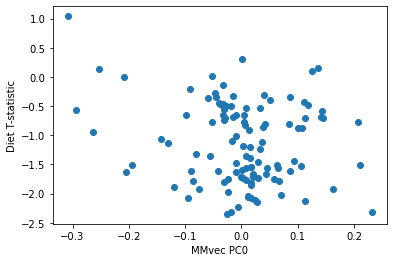

In [9]:
plt.scatter(ores.samples[1], diet_tvals.loc[ores.samples.index])
plt.xlabel('MMvec PC0')
plt.ylabel('Diet T-statistic')

## Microbial comparisons

In [10]:
# load 16S, whole genome shotgun and RNAseq data
#posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-v4.nc'
#amp_diffs = extract_differentials(amp_fname)
#amp_stats = ranking(amp_diffs, reference_percentile=90)

kang_directory = '../sfari/data/sra/Kang2017'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
amp_diffs = extract_differentials(amp_fname)
amp_stats = ranking(amp_diffs, reference_percentile=50)

amp_stats = pd.merge(amp_stats, mapping, left_index=True, right_index=True)
amp_stats = amp_stats.set_index('GOTU')

In [11]:
amp_stats.sort_values('tstat')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,kingdom,phylum,class,order,family,genus,species
GOTU,,,,,,,,,,,,,,,,
G000235885,-1.735105,0.202655,-2.045767,-1.751642,-1.398189,-42.248352,24.349160,-169.571244,0.000000e+00,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea
G900106785,-2.316564,0.312139,-2.867344,-2.290543,-1.830515,-23.776518,10.263699,-147.350043,0.000000e+00,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellamassilia,Prevotellamassilia timonensis
G000512915,-1.533658,0.252575,-1.966637,-1.516592,-1.154252,-24.040803,15.675462,-120.105375,2.464964e-315,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Barnesiella,Barnesiella viscericola
G000157935,-1.078881,0.181869,-1.353329,-1.096786,-0.772869,-32.617768,30.232952,-116.787290,1.295492e-310,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella copri
G000154525,-0.452038,0.075597,-0.570886,-0.459756,-0.323343,-79.099062,174.983071,-115.126671,3.332149e-308,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides stercoris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G000761155,4.021363,0.636351,3.023502,4.004120,5.011857,9.930698,2.469486,126.918704,0.000000e+00,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas rhizosphaerae
G000694955,0.849846,0.130636,0.626766,0.843220,1.060924,49.797953,58.596441,132.692739,0.000000e+00,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Lelliottia,Lelliottia amnigena
G001602545,0.867414,0.128473,0.665424,0.867574,1.074382,52.553289,60.586142,137.661724,0.000000e+00,Bacteria,NaN,NaN,NaN,NaN,NaN,bacteria symbiont BFo1 of Frankliniella occide...


In [12]:
common_taxa = list(set(ores.features.index) & set(amp_stats.index))
amp_stats = amp_stats.loc[common_taxa]
for i in range(ores.features.shape[1]):
    print(pearsonr(ores.features.loc[common_taxa, i], 
                   amp_stats.loc[common_taxa, 'mean']))

(0.06791682293895482, 0.5520283597005888)
(-0.29975702997013737, 0.007278016157903698)
(-0.1971298671941325, 0.08162537562357003)
(0.09333973183925083, 0.41325069403563625)
(0.25700615391776305, 0.022227224243041927)


Text(0, 0.5, 'Microbial log fold change')

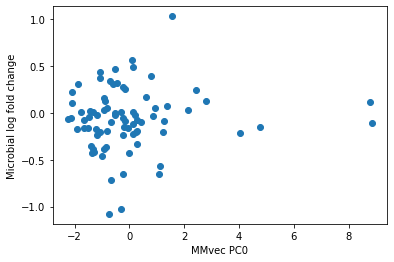

In [13]:
plt.scatter(ores.features.loc[common_taxa, 0], 
            amp_stats.loc[common_taxa, 'mean'])
plt.xlabel('MMvec PC0')
plt.ylabel('Microbial log fold change')

Takeaway, PC1 is very important - we should investigate it in more detail

In [14]:
amp_stats = amp_stats.sort_values('tstat')

# Generate microbe-diet network

In [15]:
ranks = pd.read_table(
    f'{berding_directory}/diet/mmvec-ogu-results/latent_dim_5_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt', 
    index_col=0).T
ranks = (ranks - ranks.mean(axis=0)) # clr center
microbes = ranks.index
diet_vars = ranks.columns

In [16]:
rankcoo = pd.melt(ranks.reset_index(), id_vars='index', var_name='DietCovariate')
rankcoo = rankcoo.loc[rankcoo['value'] > 0.1]
rankcoo = rankcoo.rename(columns={'index': 'microbe'})

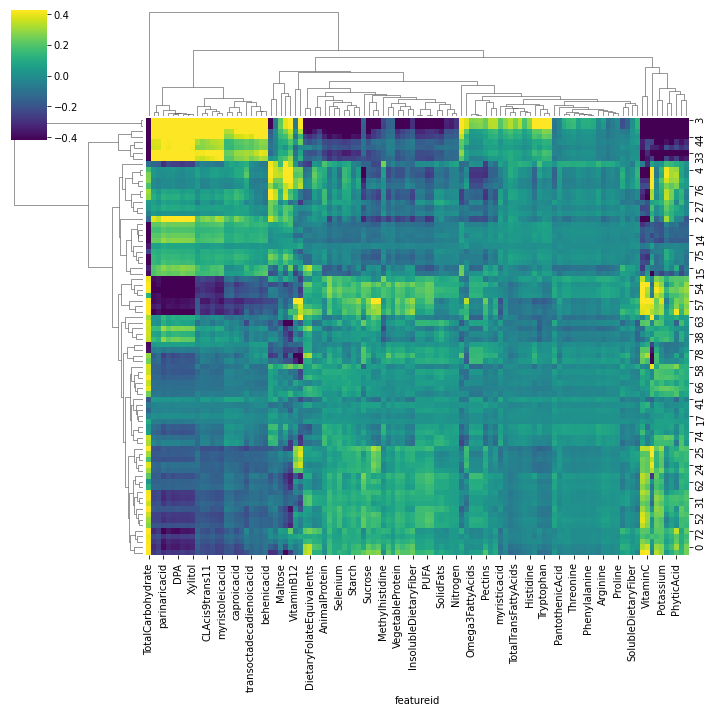

In [17]:
sns.clustermap(ranks.reset_index().iloc[:, 1:], cmap='viridis', robust=True)

In [18]:
import networkx as nx
diet_net = nx.from_pandas_edgelist(rankcoo, source='microbe', target='DietCovariate')
pos = nx.spring_layout(diet_net, k=1)
pos_df = pd.DataFrame(pos).T

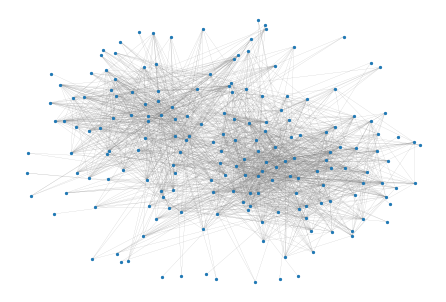

In [19]:
nx.draw(diet_net, pos=pos, node_size=5, width=0.1, edge_color='gray')

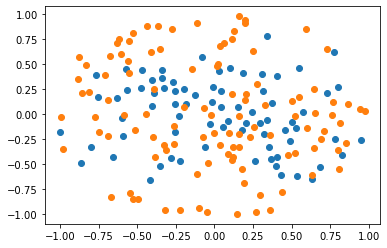

In [20]:
microbes = list(set(microbes) & set(pos_df.index))
diet_vars = list(set(diet_vars) & set(pos_df.index))

plt.scatter(pos_df.loc[microbes, 0], pos_df.loc[microbes, 1])
plt.scatter(pos_df.loc[diet_vars, 0], pos_df.loc[diet_vars, 1])

In [21]:
pos_df

,0,1
G000012825,0.152250,0.074365
TotalCarbohydrate,0.094238,-0.190639
G000435055,0.315302,0.228324
G000006865,0.183184,0.409314
G000014205,0.948538,-0.254858
...,...,...
TotalGrains,-0.616315,0.752103
WholeGrains,-0.146496,0.456721
RefinedGrains,0.523843,-0.386678
ALA,0.813095,-0.084623


focus on significant taxa and dietary variables

In [22]:
diet_substats = diet_stats[diet_stats.pval < 0.1]

In [23]:
ranks

featureid,TotalCarbohydrate,TotalProtein,AnimalProtein,VegetableProtein,Cholesterol,SFA,MUFA,PUFA,Fructose,Galactose,...,CLA,CLAcis9trans11,CLAtrans10cis12,Tagatose,AddedSugarsTotalSugars,TotalGrains,WholeGrains,RefinedGrains,ALA,SolidFats
G000012825,0.441944,0.090853,0.009761,0.193133,0.125260,0.030925,0.081333,0.095578,0.172691,-0.113114,...,-0.222580,-0.236449,-0.338899,-0.194922,0.169269,0.078127,-0.008022,0.093808,0.001873,0.057873
G000435055,0.307962,0.043731,0.000396,0.100254,0.131796,-0.018320,0.050925,0.071958,0.240490,-0.130800,...,-0.176552,-0.176018,-0.174642,-0.056358,0.053648,0.020096,-0.016126,0.024397,-0.062537,-0.031502
G000014525,-0.118366,-0.065006,0.015086,-0.253136,-0.034558,-0.035021,-0.180367,-0.290003,-0.236654,0.166291,...,0.253324,0.277016,0.445439,0.230771,0.001171,-0.169845,0.176827,-0.322672,-0.210629,0.016520
G000160675,-1.818702,-0.835459,-0.761584,-0.532702,-1.487671,-0.546729,-0.550830,-0.411297,-0.571163,0.824785,...,1.077039,1.123249,1.451559,0.386578,-0.615053,-0.132460,0.492718,-0.136092,0.281322,-0.679055
G000006865,0.175383,0.019424,0.107837,-0.204484,0.085885,-0.078204,-0.164158,-0.245020,-0.170847,0.172496,...,0.013125,0.019949,0.014383,0.592285,0.111997,-0.159545,0.575043,-0.435355,-0.276144,-0.090197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G000154425,-0.247413,-0.009036,0.034150,-0.098575,-0.024161,0.007156,-0.055942,-0.093274,-0.155907,0.089997,...,0.100869,0.103909,0.119990,0.130473,-0.002835,-0.049478,0.091676,-0.105590,-0.036864,0.019917
G000492175,0.181198,0.004279,0.032688,-0.092422,0.067218,-0.081130,-0.109974,-0.155285,-0.009516,0.081891,...,-0.039322,-0.032488,-0.019085,0.340292,0.107134,-0.099763,0.394309,-0.285680,-0.215254,-0.086684
G001244495,0.118179,0.079601,0.061155,0.105170,0.120908,0.097285,0.132616,0.157525,0.097238,-0.153885,...,-0.100235,-0.107935,-0.142078,-0.216907,-0.035463,0.072874,-0.303619,0.195042,0.104079,0.096628
G001244995,-0.380687,0.032801,0.001667,0.100079,0.000552,0.075666,0.092275,0.115966,0.018804,-0.067664,...,-0.017230,-0.025844,-0.065971,-0.251790,-0.016084,0.082236,-0.247044,0.198501,0.139916,0.091733


([], [])

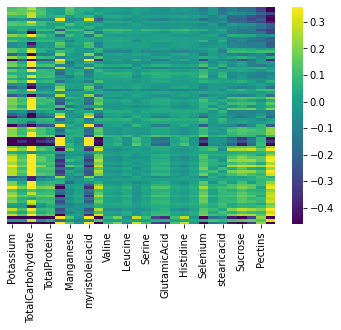

In [24]:
microbe_pc1 = ores.features[1].sort_values()
diet_pc1 = ores.samples[1].loc[diet_substats.index].sort_values()
sns.heatmap(ranks.loc[microbe_pc1.index, diet_pc1.index], robust=True,
            cmap='viridis')
plt.yticks([])

Get ASD specific taxa from meta-disease analysis

Plot dietary co-occurrence results

In [25]:
len(set(ores.features.index)), len(common_taxa), microbe_pc1.shape

(80, 79, (80,))

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 111.0)

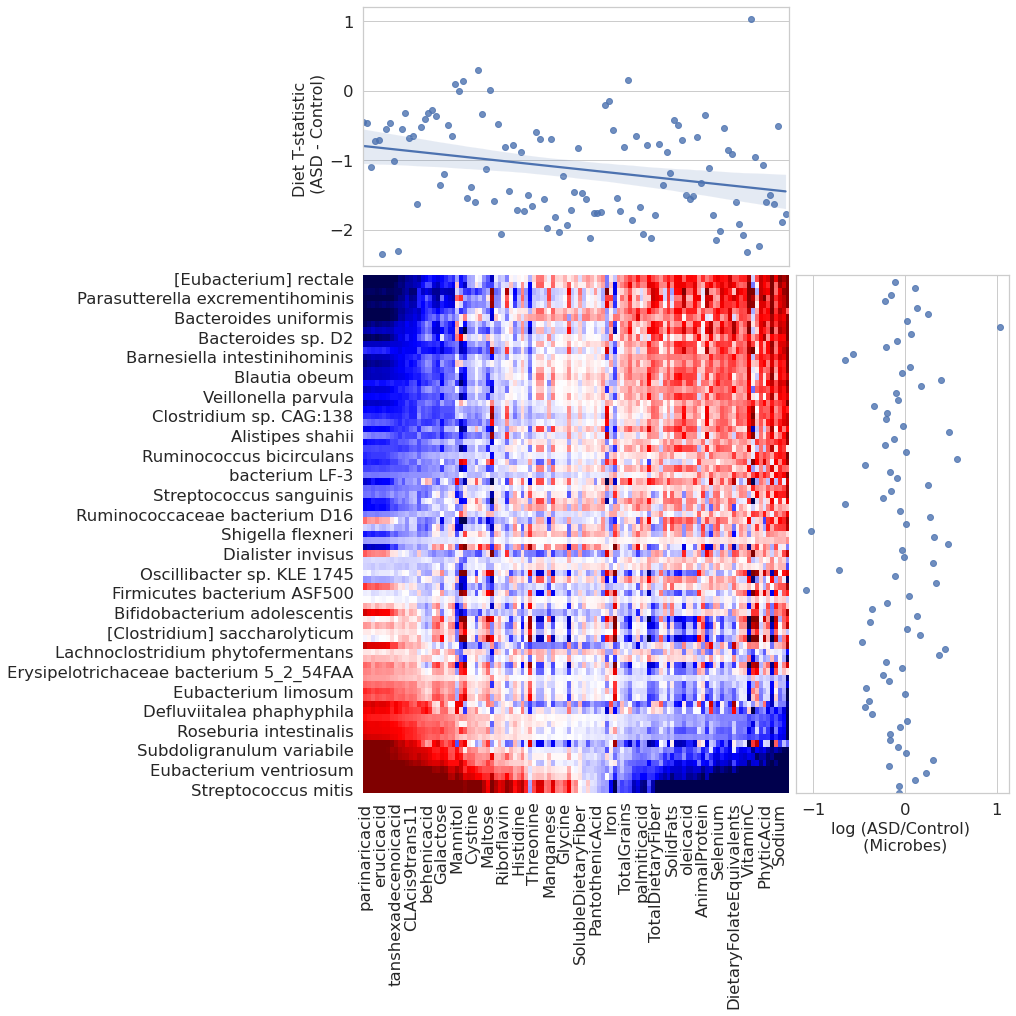

In [26]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

taxa_names = mapping.set_index('GOTU')['species']
common_taxa = list(set(ores.features.index) & set(amp_stats.index))

microbe_pc1 = ores.features.loc[common_taxa, 0].sort_values()
diet_pc1 = ores.samples[0].sort_values()

lfc = amp_stats.loc[common_taxa, 'mean']
idx = ores.features.loc[common_taxa, 0].sort_values().index
lfc = lfc.loc[idx].sort_values()

fig = plt.figure(constrained_layout=True, figsize=(14, 14))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[1:, :2])
ax2 = fig.add_subplot(gs[1:, 2])
ax3 = fig.add_subplot(gs[0, :2])


diet_substats = diet_stats[diet_stats.pval < 0.1]
#diet_pc1 = ores.samples[0].loc[diet_substats.index].sort_values()
diet_pc1 = ores.samples[0].sort_values()

cranks = ranks.loc[microbe_pc1.index, diet_pc1.index]
cranks.index = list(map(lambda x: taxa_names.loc[x], microbe_pc1.index))

g = sns.heatmap(cranks.iloc[:, ::-1], robust=True, cbar=False,
                cmap='seismic', ax=ax1)
#ax1.set_yticklabels([])
#ax1.set_xticklabels([])


ax = ax2
sns.regplot(lfc.loc[microbe_pc1.index], np.arange(len(lfc)), ax=ax, fit_reg=False)

ax.set_yticks([])
ax.set_ylim([0, len(lfc)])

ax.set_xlabel('log (ASD/Control) \n (Microbes)', 
               fontsize=16)

ax = ax3

dtv = diet_tvals.loc[diet_pc1.index]
sns.regplot(np.arange(len(dtv)), dtv.iloc[::-1],  ax=ax)
ax.set_ylabel('Diet T-statistic \n (ASD - Control)', fontsize=16)
ax.set_xticks([])
ax.set_xlim([0, len(dtv)])

#plt.tight_layout()

<ipython-input-27-ff1666fae6d4>:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  diet_stats['sig'] = (diet_stats['pval'] < 0.1).astype(np.bool)


(0.0, 111.0)

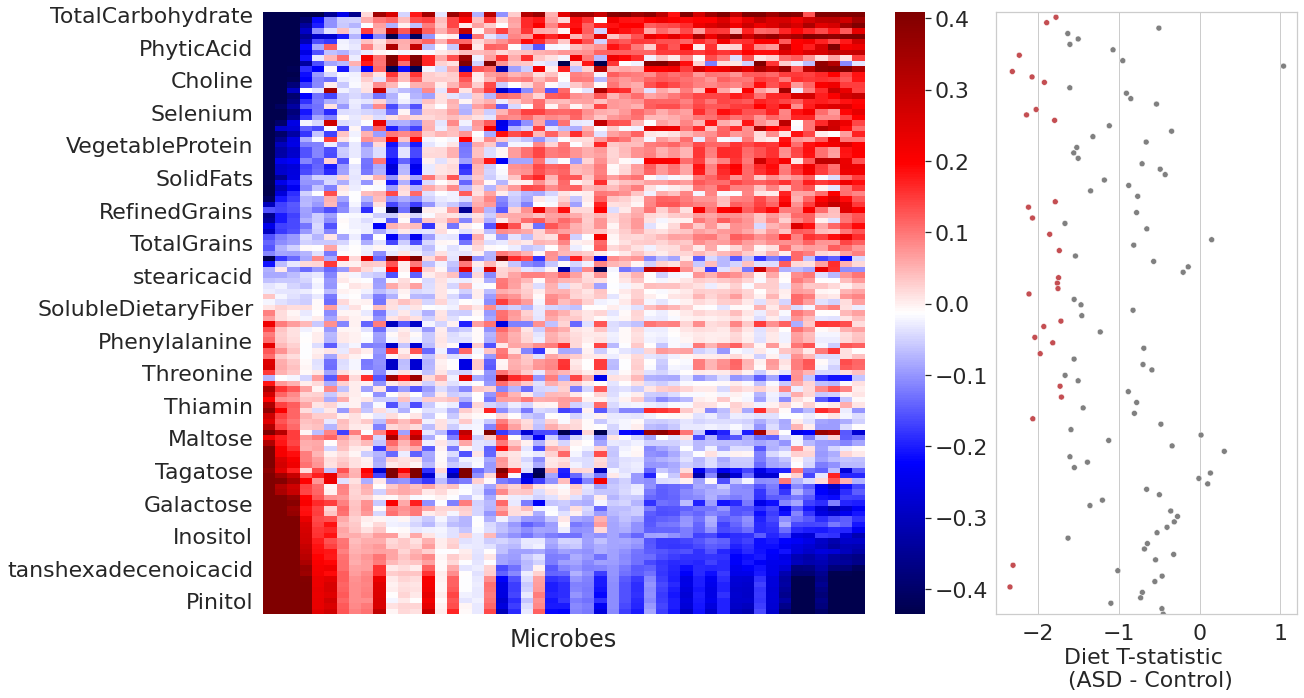

In [27]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
#with plt.style.context('dark_background'):
ast = pd.read_csv('../results/amp-crossectional-studies.csv', index_col=0)
taxa_names = mapping.set_index('GOTU')['species']
common_taxa = list(set(ores.features.index) & set(amp_stats.index) & set(ast.loc[ast['num_studies'] == 8].GOTU))


microbe_pc1 = ores.features.loc[common_taxa, 0].sort_values()
diet_pc1 = ores.samples[0].sort_values()

lfc = amp_stats.loc[common_taxa, 'mean']
idx = ores.features.loc[common_taxa, 0].sort_values().index
lfc = lfc.loc[idx].sort_values()

fig = plt.figure(constrained_layout=True, figsize=(18, 18))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[1:, :2])
ax2 = fig.add_subplot(gs[1:, 2])
#ax3 = fig.add_subplot(gs[0, :2])


diet_substats = diet_stats[diet_stats.pval < 0.1]
#diet_pc1 = ores.samples[0].loc[diet_substats.index].sort_values()
diet_pc1 = ores.samples[0].sort_values()

cranks = ranks.loc[microbe_pc1.index, diet_pc1.index]
cranks.index = list(map(lambda x: taxa_names.loc[x], microbe_pc1.index))

g = sns.heatmap(cranks.T.iloc[:, ::-1], robust=True, cbar=True,
                cmap='seismic', ax=ax1)
ax1.set_xticklabels([])
ax1.set_xlabel('Microbes', fontsize=24)


ax = ax2
diet_stats = pd.DataFrame({'tval': diet_tvals, 'pval': diet_pvals})
diet_stats = diet_stats.loc[cranks.columns]
diet_stats['idx'] = np.arange(len(diet_stats))[::-1]
diet_stats['sig'] = (diet_stats['pval'] < 0.1).astype(np.bool)

sns.scatterplot(y='idx', x='tval', hue='sig', data=diet_stats, legend=False, 
                palette={True: 'r', False:'#808080'}, s=35)
ax.set_xlabel('Diet T-statistic \n (ASD - Control)', fontsize=22)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_ylim([0, len(dtv)])

#plt.tight_layout()

Save supplemental figure

In [32]:
diet_table = cranks.T.copy()
diet_table = pd.merge(diet_stats[['tval', 'pval']], diet_table, 
                      left_index=True, right_index=True)
diet_table.to_csv('../results/supplemental_tables/Table_S7.csv')

In [ ]:
diet_stats.sort_values('pval').head(20)

In [ ]:
print(', '.join(diet_stats.sort_values('pval').head(28).index))

In [ ]:
mapping.set_index('GOTU').loc[microbe_pc1.index]

In [ ]:
def repel_labels(ax, x, y, labels, k=0.01):
    """ Taken from https://stackoverflow.com/a/34697108/1167475"""
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        if label != '':
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        shrinkA=0, shrinkB=0,
                                        connectionstyle="arc3", 
                                        color='red'), fontsize=10)
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    #ax.set_xlim([mins[0], maxs[0]])
    #ax.set_ylim([mins[1], maxs[1]])
    return mins, maxs

sns.set_style('white')

m_pc1 = pd.merge(amp_stats, pd.DataFrame({'MMvec_PC0': ores.features[0]}), left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(m_pc1['mean'], m_pc1['MMvec_PC0'])
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

def label_f(x):
    if x['pvalue'] < 1e-200:
        if 'sp.' in x['species']:
            return x['species'].replace('sp.', 'sp.\n')
        return x['species'].replace(' ', '\n')
    else:
        return ''

labels = m_pc1.apply(label_f, axis=1)

mins, maxs = repel_labels(ax, x=m_pc1['mean'], y=m_pc1['MMvec_PC0'], labels=labels, k=0.75)
        
ax.set_xlabel('log(ASD/Control) + K')
ax.set_ylabel('MMvec PC0')

xs = m_pc1['mean']
ys = m_pc1['MMvec_PC0']
ax.set_xlim([min(min(xs), mins[0]), max(max(xs), maxs[0]) + 1])
ax.set_ylim([min(min(ys), mins[1]), max(max(ys), maxs[1]) + 1])

In [ ]:
m_pc1.to_csv('../results/berding_diet_microbes.csv')

# Simplified dietary figure

In [ ]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ast = pd.read_csv('../results/amp-crossectional.csv', index_col=0)
ast = pd.merge(ast[['cluster_name', 'GOTU']], m_pc1, left_on='GOTU', right_index=True)

diet_stats['MMvec_PC0'] = ores.samples[1]

sns.scatterplot(data=ast, x='mean', y='MMvec_PC0', hue='cluster_name', legend=False, 
                palette={'num': 'r', 'neutral':'#808080', 'denom': 'g'}, ax=ax[0])
sns.scatterplot(data=diet_stats, x='tval', y='MMvec_PC0', hue='sig', legend=False, 
                palette={True: 'r', False:'#808080'}, ax=ax[1])
ax[1].set_xlabel('T(ASD - Control) \n (Diet)')
ax[0].set_xlabel('log(ASD / Control) + K \n (Microbes)')

ax[0].set_ylabel('MMvec PC0')
ax[1].set_ylabel('MMvec PC0')
plt.tight_layout()

In [ ]:
diet_stats